In [1]:
from scipy.linalg import eigh
from scipy.sparse import diags
from scipy.interpolate import interp1d
from scipy.integrate import quad

import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=True)

np.set_printoptions(precision=3, suppress=True)

In [2]:
def discrete_bloch(x, V, q):
    
    dx = x[1] - x[0]    

    KE_particle = diags(
        [
            -1/dx**2 * np.ones(len(x)-1), 
            2/dx**2 * np.ones(len(x)), 
            -1/dx**2 * np.ones(len(x)-1)

        ], [-1, 0, 1])

    KE_lattice = diags(q**2 * np.ones(len(x)), 0)

    KE_cross = -2j * q * diags(
        [
            -1/(2*dx) * np.ones(len(x)-1), 
            1/(2*dx) * np.ones(len(x)-1)
        
        ], [-1, 1])

    Hamiltonian = (KE_particle + KE_lattice + KE_cross + diags(V, 0)).todense()
    Hamiltonian[0, -1] = Hamiltonian[-1, 0] = -1/dx**2

    E, phi = eigh(Hamiltonian) # evals, evecs

    return np.real(E), phi.T/np.sqrt((dx * np.sum(np.abs(phi.T)**2, axis = 0)))

In [3]:
x = np.linspace(0, 1, 1001)
V = -800 * np.sin(np.pi * x) ** 2
# V = 1000 * np.concatenate([(np.cos(2 * np.pi * x) ** 2 - 1)[:500], 0.6 * (np.cos(2 * np.pi * x) ** 2 - 1)[500:]])
dx = x[1] - x[0]

In [4]:
# First Brillouin Zone
q = np.linspace(-np.pi, np.pi, 50)
# Bloch u_k(x) and energies E_k
psi = np.empty((len(q), len(x), len(x)), dtype = np.complex128)
E = np.empty((len(q), len(x)), dtype = np.complex128)

In [ ]:
for i, k in tqdm(enumerate(q)):
    E[i], psi[i] = discrete_bloch(x, V, k)

In [6]:
# def get_wannier(bloch, k, x, R, band_num):
#     N = len(k)
#     return 1/np.sqrt(N) * np.sum(np.multiply(bloch[:, band_num, :], np.exp(1j * np.outer(k, x - R)[0])), axis = 0)

In [7]:
# k is index of wave-number
def func_bloch(discrete_bloch, x, k, band_num):
    return lambda r: interp1d(x, discrete_bloch[k, band_num, :])(r % 1)

In [8]:
def func_wannier(discrete_bloch, k, x, R, band_num):
    N = len(k)
    def func(r):
        bloch_vals = np.array([func_bloch(discrete_bloch, x, elt, band_num)(r) for elt in range(len(k))])
        return 1/np.sqrt(N) * np.sum(bloch_vals * np.exp(1j * k * (r - R)), axis = 0)

    return func

In [23]:
wannier = func_wannier(psi, q, x, -1.2, 0)
bloch = func_bloch(psi, x, 0, 0)

C:\Users\saksh\AppData\Local\Temp/ipykernel_10808/1788927369.py:3: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  plt.plot(x_grid, np.abs(np.vectorize(wannier)(x_grid))**2/quad(lambda x: np.abs(wannier(x))**2, -2, -1)[0], c = "C17", label = "Wannier")


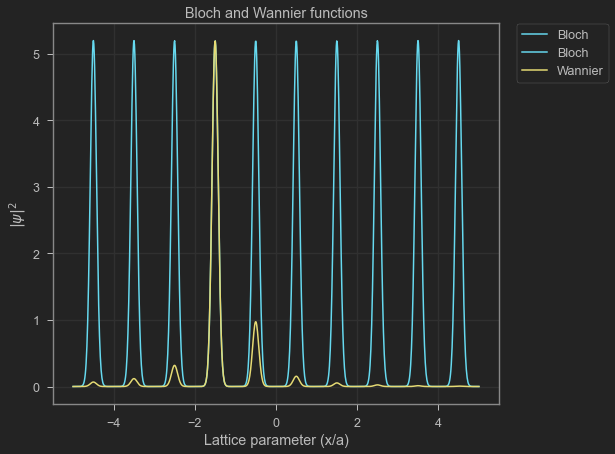

In [24]:
x_grid = np.linspace(-5, 5, 1000)
plt.plot(x_grid, np.abs(np.vectorize(bloch)(x_grid))**2, dx, c= "C15", label = "Bloch")
plt.plot(x_grid, np.abs(np.vectorize(wannier)(x_grid))**2/quad(lambda x: np.abs(wannier(x))**2, -2, -1)[0], c = "C17", label = "Wannier")
plt.xlabel("Lattice parameter (x/a)")
plt.ylabel("$|\psi|^2$")
plt.title("Bloch and Wannier functions")
plt.legend(bbox_to_anchor=(1.025, 1.015))


In [35]:
def multiple_formatter(denominator=2, number=np.pi, latex='\pi'):
    def gcd(a, b):
        while b:
            a, b = b, a%b
        return a
    def _multiple_formatter(x, pos):
        den = denominator
        num = int(np.rint(den*x/number))
        com = gcd(num,den)
        (num,den) = (int(num/com),int(den/com))
        if den==1:
            if num==0:
                return r'$0$'
            if num==1:
                return r'$%s$'%latex
            elif num==-1:
                return r'$-%s$'%latex
            else:
                return r'$%s%s$'%(num,latex)
        else:
            if num==1:
                return r'$\frac{%s}{%s}$'%(latex,den)
            elif num==-1:
                return r'$\frac{-%s}{%s}$'%(latex,den)
            else:
                return r'$\frac{%s%s}{%s}$'%(num,latex,den)
    return _multiple_formatter

class Multiple:
    def __init__(self, denominator=2, number=np.pi, latex='\pi'):
        self.denominator = denominator
        self.number = number
        self.latex = latex
    def locator(self):
        return plt.MultipleLocator(self.number / self.denominator)
    def formatter(self):
        return plt.FuncFormatter(multiple_formatter(self.denominator, self.number, self.latex))

Text(0.5, 1.0, 'Periodic Potential')

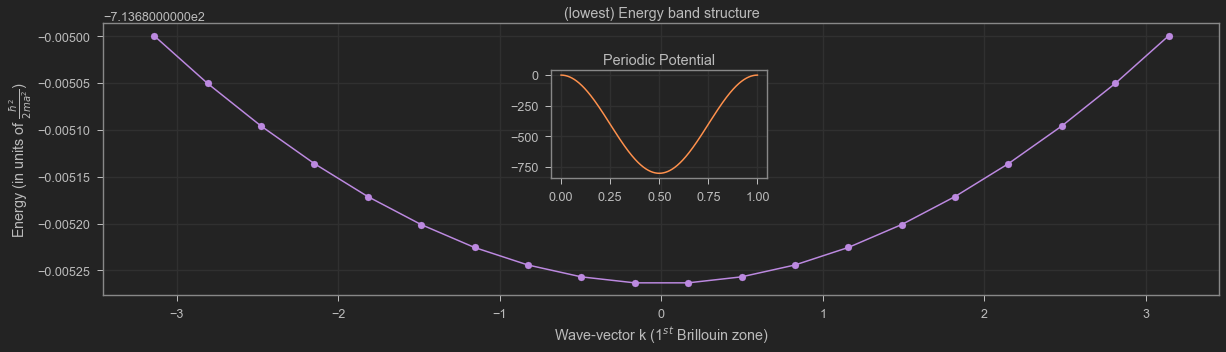

In [36]:
fig = plt.figure(figsize=(20, 5))
plt.plot(q, np.real(E)[:, 0], c = "C10", zorder = 5)
plt.scatter(q, np.real(E)[:, 0], c = "C10", zorder = 5)

ax = plt.gca()
# ax.xaxis.set_major_locator(MultipleLocator(np.pi/2))
# ax.xaxis.set_major_formatter(plt.FuncFormatter(multiple_formatter()))
ax.set_xlabel(r"Wave-vector k (1$^{st}$ Brillouin zone)")
ax.set_ylabel(r"Energy (in units of $\frac{\hbar^2}{2ma^2}$)")
ax.set_title("(lowest) Energy band structure")

left, bottom, width, height = [0.436, 0.45, 0.15, 0.3]
ax2 = fig.add_axes([left, bottom, width, height])
ax2.plot(x, V, c = "C4", label = "Potential")
ax2.set_title("Periodic Potential")